# Imports

In [1]:
#!pip install pycaret
#from pycaret.regression import setup, compare_models

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
import scipy.stats

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor

import optuna

# Load Data

In [3]:
train_original = pd.read_csv('./res/input/train.csv')
test_original = pd.read_csv('./res/input/test.csv')
sample_submission = pd.read_csv('./res/input/sample_submission.csv')

# EDA : Exploratory Data Analysis

In [4]:
train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [6]:
sample_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


/var/folders/_v/jcdv4chx5xz3gsy0v2zv8dcr0000gn/T/ipykernel_16828/4042232294.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_original.get("SalePrice"), kde=False)


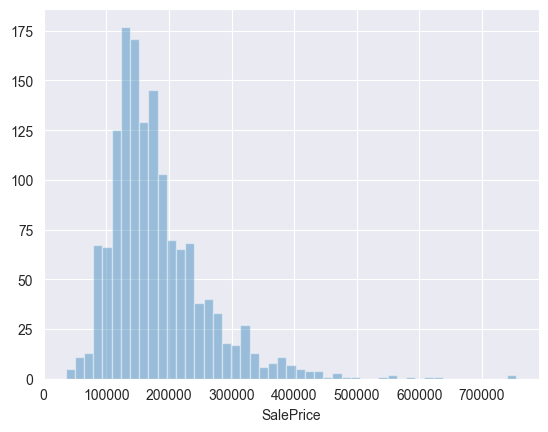

In [61]:
#distribution of values in target feature
sns.distplot(train_original.get("SalePrice"), kde=False)
plt.show()

==> The target feature is right skewed.

<Axes: >

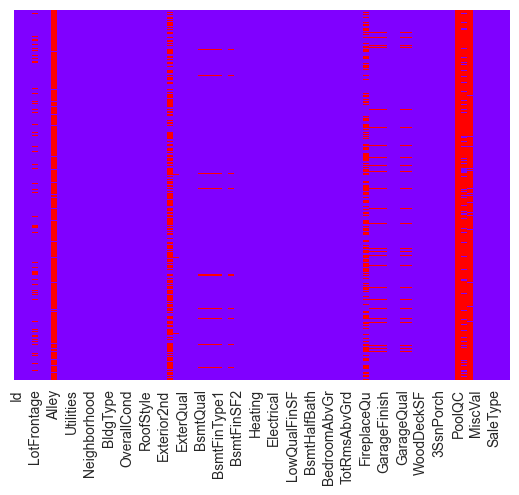

In [62]:
sns.heatmap(train_original.isnull(),yticklabels=False,cbar=False, cmap='rainbow')

<Axes: >

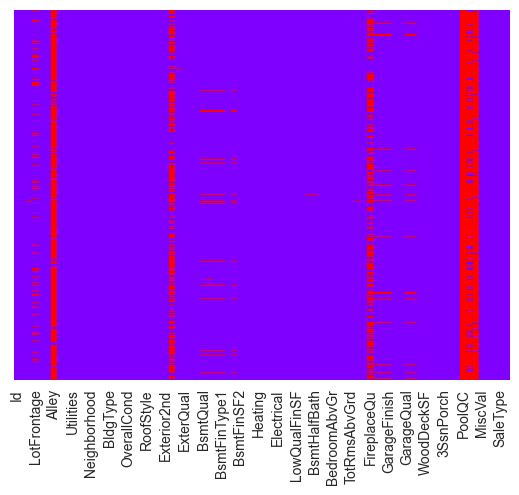

In [9]:
sns.heatmap(test_original.isnull(),yticklabels=False,cbar=False,cmap='rainbow')

# Combine Train and Test Sets
- Since, test data set is available, it's good to use combined mean or mode values for filling missing values.

In [10]:
train_target = train_original['SalePrice']
test_ids = test_original['Id']

train_id_n_target_removed = train_original.drop(['Id', 'SalePrice'], axis=1)
test_id_removed = test_original.drop('Id', axis=1)

data_combined = pd.concat([train_id_n_target_removed, test_id_removed], axis=0).reset_index(drop=True)

In [11]:
data_combined

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [12]:
train_target

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

# Data Cleaning

In [13]:
data = data_combined.copy()

## Ensure Proper Data Types

In [14]:
# Check for categorical variables encoded as numerical
data.select_dtypes(np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,6,2006
2915,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,286.0,0,24,0,0,0,0,0,4,2006
2916,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,576.0,474,0,0,0,0,0,0,9,2006
2917,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [15]:
data['MSSubClass'] = data['MSSubClass'].astype(str)

## Fill Categorical Missing Values
- Some missing values such as 'NA' or 'None' in some categorical features are not actually missing values. They actually mean something. It's not actually a missing value; but a valid value.
    - For example, 'NA' in 'Alley' feature means 'No Alley Access'.
    - So for such features, we fill missing values with 'None' or 'NA'.


In [16]:
data1 = data.copy()
data1.select_dtypes('object').isna().sum()

MSSubClass          0
MSZoning            4
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType       1766
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
PoolQC           2909
Fence            2348
MiscFeature      2814
SaleType            1
SaleCondition       0
dtype: int64

In [17]:
# Impute categorical features with meaningful NA using 'None' value
for column in [
    'Alley',
    'BsmtQual', #
    'BsmtCond', #
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',#
    'GarageType',
    'GarageFinish',
    'GarageQual',#
    'GarageCond',#
    'PoolQC',#
    'Fence',
    'MiscFeature'
]:
    data1[column] = data[column].fillna("None")

# Impute using the column mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data1[column] = data[column].fillna(data[column].mode()[0])

## Fill Numeric Missing Values
- Use KNN regression --> look at the neighbors and fill the missing value with the mean of the neighbors


In [18]:
data2 = data1.copy()
data2.select_dtypes(np.number).isna().sum()

LotFrontage      486
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt      159
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [19]:
def knn_impute(df, column):
    df = df.copy()

    # numeric columns
    numeric_df = df.select_dtypes(np.number)
    # get numeric columns without missing values
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns

    # select non-null values of the target feature
    y_train = numeric_df.loc[numeric_df[column].isna() == False, column]
    # retrieve corresponding other feature values for y_train from the features set without any missing values
    x_train = numeric_df.loc[numeric_df[column].isna() == False, non_na_columns]
    # retrieve corresponding other feature values for the missing data set of the target feature
    x_test = numeric_df.loc[numeric_df[column].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(x_train, y_train)
    
    y_pred = knn.predict(x_test)

    # fill missing values with the predicted values
    df.loc[df[column].isna() == True, column] = y_pred
    
    return df

In [20]:
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea'
]:
    data2 = knn_impute(data2, column)

# Feature Engineering

In [21]:
data3 = data2.copy()

In [22]:
data3["SqFtPerRoom"] = data3["GrLivArea"] / (data3["TotRmsAbvGrd"] + data3["FullBath"] + data3["HalfBath"] + data3["KitchenAbvGr"])

data3['Total_Home_Quality'] = data3['OverallQual'] + data3['OverallCond']

data3['Total_Bathrooms'] = (data3['FullBath'] + (0.5 * data3['HalfBath'])
                            + data3['BsmtFullBath'] + (0.5 * data3['BsmtHalfBath']))

data3["HighQualSF"] = data3["1stFlrSF"] + data3["2ndFlrSF"]

# Feature Transformations

## Log Transform for Skewed Features
Skewness occur when the data is concentrated more towards one end of the range and has a long tail stretching toward the other end.

Skewed features can negatively affect the performance of certain machine learning algorithms such as linear regression or K-means clustering as they assume that the data is normally distributed.

By transforming skewed features into a more symmetric distribution, the data can better meet the assumptions of various algorithms, leading to improved model performance and more reliable predictions.

#### 2 main types of skewness:
1. **`Positive Skewness`**: the mean is greater than the median
2. **`Negative Skewness`**: the mean is less than the median


#### Transformations to deal with skewed features
1. **`Logarithmic Transformation`**: Applying the logarithm to the feature values, compress the range of high values, reducing the impact of the long tail.
2. **`Square Root Transformation`**: Taking the square root of the feature values, reduce the impact of extreme values.
3. **`Box-Cox Transformation`**: More generalized method that can handle different types of skewness and find the optimal power transformation to make the distribution more normal.
4. **`Min-Max Scaling or Z-score Scaling`**: In some cases, simply scaling the values to a certain range (e.g., [0, 1]) or standardizing them (mean of 0 and standard deviation of 1) can help mitigate the impact of skewness.


In [23]:
scipy.stats.skew(data3['LotFrontage'])

1.3407511399227516

In [24]:
data4 = data3.copy()

In [25]:
# initialize skew_df to numerical feature name set
skew_df = pd.DataFrame(data4.select_dtypes(np.number).columns, columns=['Feature'])
# calculate skewness for each feature and store in skew_df
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data4[feature]))
# calculate Absolute Skewness
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
# select columns with more than 0.5 Absolute Skewness to apply transformation
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

In [26]:
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.340751,1.340751,True
1,LotArea,12.822431,12.822431,True
2,OverallQual,0.197110,0.197110,False
3,OverallCond,0.570312,0.570312,True
4,YearBuilt,-0.599806,0.599806,True
5,YearRemodAdd,-0.451020,0.451020,False
6,MasVnrArea,2.603682,2.603682,True
7,BsmtFinSF1,1.425516,1.425516,True
8,BsmtFinSF2,4.146111,4.146111,True
9,BsmtUnfSF,0.919322,0.919322,True


In [27]:
data4[skew_df.query("Skewed == True")['Feature'].values].describe()

,LotFrontage,LotArea,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SqFtPerRoom,Total_Home_Quality,HighQualSF
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,70.154916,10168.114080,5.564577,1971.312778,102.189654,441.332580,49.576841,560.797670,1051.679822,1159.581706,...,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,157.116695,11.653649,1496.065433
std,22.697641,7886.996359,1.113131,30.291442,178.934095,455.559081,169.176867,439.470508,440.722380,392.362079,...,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,27.923999,1.712435,503.675790
min,21.000000,1300.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81.400000,2.000000,334.000000
25%,60.000000,7478.000000,5.000000,1953.500000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,137.142857,11.000000,1120.000000
50%,70.000000,9453.000000,5.000000,1973.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.285714,12.000000,1440.000000
75%,80.100000,11570.000000,6.000000,2001.000000,164.000000,733.000000,0.000000,805.000000,1302.000000,1387.500000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,172.333333,13.000000,1742.500000
max,313.000000,215245.000000,9.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,352.625000,19.000000,5642.000000


- minimum value of some features are 0. So, we can't apply log transformation directly. As log(0) is undefined.
- So, we add 1 to all values and then apply log transformation. --> `np.log1p` does this.

In [28]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data4[column] = np.log1p(data4[column])

## Cosine Transform for Cyclical Features

**Cyclic features(aka periodic features)**: variables that exhibit a repeating pattern over time or in a circular fashion.
- Cyclic features don't follow a linear relationship with the target variable but instead have a circular or seasonal nature.
- When working with cyclic features, traditional linear models may not be appropriate since they do not account for the cyclical nature of the data.

#### Examples:
1. Time of Day: cyclic feature as it repeats every 24 hours.
2. Months of the Year: cyclic features, repeating every 12 months. E.g:, January and December are equally spaced from each other.
3. Days of the Week: cyclic feature, repeating every 7 days.
4. Angles in Degrees: angles such as azimuth and elevation are considered cyclic features because they represent positions on a circle.



#### Handling cyclic features
- convert them into trigonometric features, such as sine and cosine transformations.
    - Enable us to map the cyclic data onto a circular space, where the cyclical nature is preserved.

Feature `MoSold` is a cyclic feature. It has values from 1 to 12.
To convert it into a trigonometric feature, we need to fine constant c, such that
    cos(cx) cycle through 2pi as x cycles through 12 values from 1 to 12.
    ![cos cycle](./res/img/find_c_for_cosine.png)
Used cosine negative as it represents the temperature cycle better. As it's cold on both Jan and Dec
- now this feature sort of recognizes the summer and winter


In [29]:
data5 = data4.copy()

In [30]:
data5['MoSold'] = (-np.cos(0.5236 * data5['MoSold']))

# Encode Categorical Features

## One Hot Encoding
- used since there's no inherent order or hierarchy among the categories
- preserves the distinct categories as separate binary features
    - helps the model to understand and learn from the categorical information more effectively
- make it easier to interpret the importance of each category in the model's predictions
    - Each category's coefficient in the model can directly indicate its impact on the outcome

In [31]:
data6 = data5.copy()

In [32]:
# create a one-hot encoding of categorical variables (for all object type columns)
data6 = pd.get_dummies(data6)

# Scaling
Scaling: process of transforming the numerical features of a dataset to a consistent range or scale.
- it helps to ensure that all features have similar magnitudes and do not bias  machine learning algorithms toward features with larger values.

Algorithms that use distance metrics, like K-Nearest Neighbors, often benefit from scaling to avoid the influence of variables with larger magnitudes.
Algorithms, such as decision trees or random forests, are invariant to feature scaling and do not necessarily require it.

In a **Production model**, It's important to scale the data after splitting it into training and testing sets.
- Scaling should only be applied to the training data and then propagated to the testing data using the parameters learned from the training set.
- This ensures that the scaling process does not leak information from the testing set into the training process.

### Scaling methods:
1. Min-Max Scaling (Normalization):
    - scales the features to a fixed range, usually between 0 and 1
    - achieved by subtracting the minimum value of the feature and then dividing by the range (the difference between the maximum and minimum values)
2. Standardization (Z-score Scaling):
    - scales the features to have a mean of 0 and a standard deviation of 1
    - accomplished by subtracting the mean of the feature and then dividing by the standard deviation
    - Standardization is preferred over Min-Max scaling when the data contains outliers or when the algorithm relies on the assumption of `normality`
3. Robust Scaling:
    - scales the features based on their median and interquartile range (IQR)
    - more robust to outliers than Min-Max scaling or Standardization
4. Log Transformation:
    - For skewed data distributions, applying the logarithm can help normalize the data and make it more suitable for certain algorithms.

In [33]:
data7 = data6.copy()

In [34]:
scaler = StandardScaler()
scaler.fit(data7)

data7 = pd.DataFrame(scaler.transform(data7), index=data7.index, columns=data7.columns)

In [35]:
data7

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.064176,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.210174,0.783229,-0.363076,-0.326949,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.536077,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804554,0.892444,-0.363076,0.013428,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.066112,0.457629,0.646183,-0.435439,0.975922,0.848965,1.137926,0.658154,-0.363076,0.240016,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295084,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804554,0.386923,-0.363076,0.356870,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.677357,0.922662,1.355551,-0.435439,0.943542,0.753229,1.430432,0.758108,-0.363076,0.304906,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.284214,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804554,-1.418196,-0.363076,0.362780,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.284214,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804554,0.438424,-0.363076,0.031907,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.549545,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804554,0.967658,-0.363076,-3.015455,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.200527,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804554,0.535612,-0.363076,0.390461,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


# Target Transformation
- Have to undo the target transformation after predictions are computed
- it's crucial to ensure that the transformations are consistent across different folds during cross-validation to prevent data leakage and overfitting

Primary goal: to improve the predictive performance of ML models by transforming the target variable in a way that makes the underlying patterns more evident or easier for the model to learn.

Application: in regression problems, where the target variable is continuous.

#### Techniques:
1. Log Transformation:
    -   If the target variable has a right-skewed distribution (positive skewness), applying a logarithmic transformation can help make the data more symmetric
    - important especially for linear regression
2. Box-Cox Transformation:
    - more general transformation that can handle various types of target variable distributions
    - applies a power transformation to stabilize the variance and make the data more normally distributed
3. Sqrt (Square Root) Transformation:
    - useful for stabilizing variance and reducing the impact of extreme values in the target variable
4. Inverse Transformation:
    - if the relationship between the features and the target variable is better represented in reverse, applying an inverse transformation (e.g., taking the reciprocal) may improve model performance
5. Target Binning:
    - Binning the target variable into discrete intervals and encoding the bins with numerical values can be helpful when dealing with regression problems where the target has a more complex relationship with the features

In [36]:
data8 = data7.copy()

In [37]:
train_target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/var/folders/_v/jcdv4chx5xz3gsy0v2zv8dcr0000gn/T/ipykernel_16828/3999395935.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_target, kde=True, fit=scipy.stats.norm)
/var/folders/_v/jcdv4chx5xz3gsy0v2zv8dcr0000gn/T/ipykernel_16828/3999395935.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.dis

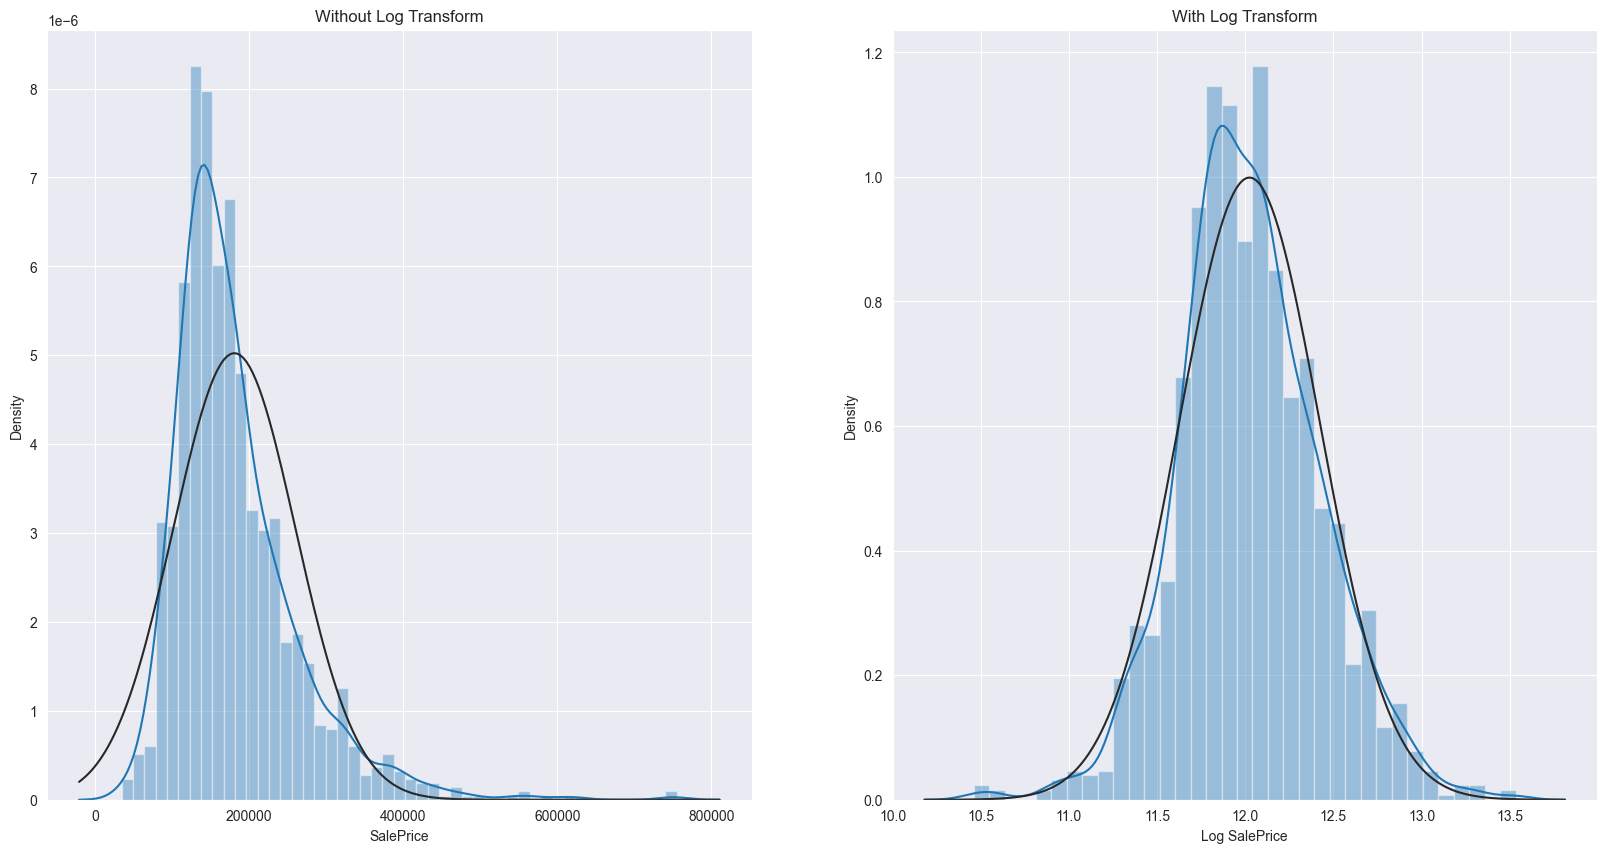

In [38]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(train_target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
# can do log transformation on the target variable to make it more normally distributed without shifting the values as target variable minimum is greater than zero
sns.distplot(np.log(train_target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [39]:
log_target = np.log(train_target)
# to transform back to original: e^(log_target) or np.exp(log_target)

# Split Data

In [40]:
train_final = data8.loc[:train_original.index.max(), :].copy()
test_final = data8.loc[train_original.index.max() + 1:, :].reset_index(drop=True).copy()

In [41]:
train_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.064176,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.210174,0.783229,-0.363076,-0.326949,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.536077,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804554,0.892444,-0.363076,0.013428,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.066112,0.457629,0.646183,-0.435439,0.975922,0.848965,1.137926,0.658154,-0.363076,0.240016,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295084,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804554,0.386923,-0.363076,0.356870,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.677357,0.922662,1.355551,-0.435439,0.943542,0.753229,1.430432,0.758108,-0.363076,0.304906,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.200527,-0.231508,-0.063185,-0.435439,0.911146,0.753229,-0.804554,-1.418196,-0.363076,0.660828,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1456,0.711638,0.767440,-0.063185,0.454875,0.227056,0.178812,1.021136,0.820898,2.351183,0.403330,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1457,-0.020100,0.029092,0.646183,2.514892,-0.996100,1.040437,-0.804554,0.467619,-0.363076,0.616343,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1458,0.066112,0.170303,-0.772552,0.454875,-0.696444,0.561757,-0.804554,-0.105594,3.329113,-3.015455,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


In [42]:
test_final

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.536077,0.521437,-0.772552,0.454875,-0.332070,-1.113625,-0.804554,0.645518,2.285649,-0.013563,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.572040,0.923625,-0.063185,0.454875,-0.431241,-1.257229,0.984472,0.873044,-0.363076,0.204364,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.310504,0.862607,-0.772552,-0.435439,0.846305,0.657493,-0.804554,0.821322,-0.363076,-0.375189,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,0.462798,0.222291,-0.063185,0.454875,0.878733,0.657493,0.356462,0.729841,-0.363076,0.083804,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
4,-1.252596,-1.130892,1.355551,-0.435439,0.683917,0.370284,-0.804554,0.452704,-0.363076,0.695621,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-3.284214,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804554,-1.418196,-0.363076,0.362780,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1455,-3.284214,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804554,0.438424,-0.363076,0.031907,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
1456,2.549545,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804554,0.967658,-0.363076,-3.015455,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
1457,-0.200527,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804554,0.535612,-0.363076,0.390461,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


# Model Selection

In [43]:
#_ = setup(data=pd.concat([train_final, log_target], axis=1), target='SalePrice')

In [44]:
#compare_models()

# Hyperparameter Optimization

In [47]:
kf = KFold(n_splits=10)

def br_objective(trial):
    n_iter = trial.suggest_int('n_iter', 50, 600)
    tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
    alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10.0)
    alpha_2 = trial.suggest_loguniform('alpha_2', 1e-8, 10.0)
    lambda_1 = trial.suggest_loguniform('lambda_1', 1e-8, 10.0)
    lambda_2 = trial.suggest_loguniform('lambda_2', 1e-8, 10.0)
    
    model = BayesianRidge(
        n_iter=n_iter,
        tol=tol,
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        lambda_1=lambda_1,
        lambda_2=lambda_2
    )
    
    model.fit(train_final, log_target)
    
    cv_scores = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    
    return np.mean(cv_scores)

In [48]:
study = optuna.create_study(direction='minimize')
study.optimize(br_objective, n_trials=100)

[I 2023-07-23 11:38:55,497] A new study created in memory with name: no-name-b5b0a441-4ee3-44ab-8b05-616015985c11
/var/folders/_v/jcdv4chx5xz3gsy0v2zv8dcr0000gn/T/ipykernel_16828/1347700693.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  tol = trial.suggest_loguniform('tol', 1e-8, 10.0)
/var/folders/_v/jcdv4chx5xz3gsy0v2zv8dcr0000gn/T/ipykernel_16828/1347700693.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha_1 = trial.suggest_loguniform('alpha_1', 1e-8, 10.0)
/var/folders/_v/jcdv4chx5xz3gsy0v2zv8dcr0000gn/T/ipykernel_16828/1347700693.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

In [49]:
study.best_params

{'n_iter': 417,
 'tol': 0.04624600543513187,
 'alpha_1': 0.7339275450796515,
 'alpha_2': 9.789328049058188,
 'lambda_1': 4.490013986457229,
 'lambda_2': 7.03863921689024e-08}

# Bagging Ensemble

In [50]:
catboost_params = {
    'iterations': 6000,
    'learning_rate': 0.005,
    'depth': 4,
    'l2_leaf_reg': 1,
    'eval_metric':'RMSE',
    'early_stopping_rounds': 200,
    'random_seed': 42
}

br_params = {
    'n_iter': 192,
    'tol': 0.16864712769300896,
    'alpha_1': 1.553213938328706e-07,
    'alpha_2': 3.1556958635072267e-07,
    'lambda_1': 221.96903608719495,
    'lambda_2': 4.334131018104939e-06
}

lightgbm_params = {
    'num_leaves': 39,
    'max_depth': 2,
    'learning_rate': 0.13705339989856127,
    'n_estimators': 273
}

ridge_params = {
    'alpha': 631.1412445239156
}

In [51]:
models = {
    "catboost": CatBoostRegressor(**catboost_params, verbose=0),
    "br": BayesianRidge(**br_params),
    "lightgbm": LGBMRegressor(**lightgbm_params),
    "ridge": Ridge(**ridge_params),
    "omp": OrthogonalMatchingPursuit()
}

In [52]:
for name, model in models.items():
    model.fit(train_final, log_target)
    print("Model trained: " + name)

Model trained: catboost


/Users/shadhini/.local/share/virtualenvs/ML-Zc0Z4auO/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(


Model trained: br
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4278
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 215
[LightGBM] [Info] Start training from score 12.024051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

# Evaluate

In [53]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    # use neg_mean_squared_error as scoring function expect higher values to indicate better performance
    result = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

/Users/shadhini/.local/share/virtualenvs/ML-Zc0Z4auO/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
/Users/shadhini/.local/share/virtualenvs/ML-Zc0Z4auO/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
/Users/shadhini/.local/share/virtualenvs/ML-Zc0Z4auO/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
/Users/shadhini/.local/share/virtualenvs/ML-Zc0Z4auO/lib/python3.11/site-packages/sklearn/linear_model/_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
/Users/shadhini/.local/share/virtualenvs/ML-Zc0Z4auO/lib/python3.11/site-packages/sklearn/linear

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4164
[LightGBM] [Info] Number of data points in the train set: 1314, number of used features: 210
[LightGBM] [Info] Start training from score 12.026856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [54]:
results

{'catboost': array([1.11929937, 1.09666502, 1.10630611, 1.15783223, 1.15326857,
        1.10748412, 1.1243147 , 1.10102192, 1.12325019, 1.13434938]),
 'br': array([1.12240777, 1.10455283, 1.1237717 , 1.1682768 , 1.15486982,
        1.12453143, 1.12547187, 1.10275145, 1.18194498, 1.13270499]),
 'lightgbm': array([1.12896743, 1.10435067, 1.11376237, 1.16835401, 1.16695822,
        1.11338021, 1.1284236 , 1.10885958, 1.14525677, 1.14087521]),
 'ridge': array([1.12253224, 1.10524384, 1.12399044, 1.16948183, 1.15667677,
        1.12126013, 1.12619719, 1.10348803, 1.18012236, 1.13322927]),
 'omp': array([1.13223077, 1.09725882, 1.12930056, 1.18311203, 1.15621703,
        1.15856033, 1.12668149, 1.11595193, 1.17872568, 1.15502105])}

In [55]:
for name, result in results.items():
    print("==================================\n")
    print(name)
    print("Mean:" + str(np.mean(result)))
    print("Std:" + str(np.std(result)))


catboost
Mean:1.1223791619050065
Std:0.019914581953355874

br
Mean:1.1341283632121566
Std:0.024810623333683567

lightgbm
Mean:1.131918806444864
Std:0.021907522461068595

ridge
Mean:1.1342222096150594
Std:0.024725198621401896

omp
Mean:1.143305967920284
Std:0.02615240047297118


# Combine Predictions

In [56]:
final_predictions = (
    0.45 * np.exp(models['catboost'].predict(test_final)) +
    0.2 * np.exp(models['br'].predict(test_final)) +
    0.2 * np.exp(models['lightgbm'].predict(test_final)) +
    0.075 * np.exp(models['ridge'].predict(test_final)) +
    0.075 * np.exp(models['omp'].predict(test_final))
)

In [57]:
final_predictions

array([123724.64752796, 157647.45579979, 180566.62090249, ...,
       160093.08848622, 115849.60605204, 220700.1232477 ])

# Make Submission

In [58]:
from sklearn.metrics import mean_squared_error

train_predictions = (
    0.45 * np.exp(models['catboost'].predict(train_final)) +
    0.2 * np.exp(models['br'].predict(train_final)) +
    0.2 * np.exp(models['lightgbm'].predict(train_final)) +
    0.075 * np.exp(models['ridge'].predict(train_final)) +
    0.075 * np.exp(models['omp'].predict(train_final))
)

# Calculate the Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(train_target, train_predictions)

# Calculate the Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate the logarithm of RMSE (log RMSE)
log_rmse_train = np.log(rmse_train)
print("MSE (Training set):", mse_train)
print("RMSE (Training set):", rmse_train)
print("Log RMSE (Training set):", log_rmse_train)

MSE (Training set): 216105731.36728323
RMSE (Training set): 14700.535070781718
Log RMSE (Training set): 9.595639171477293


In [59]:
submission = pd.concat([test_ids, pd.Series(final_predictions, name='SalePrice')], axis=1)
submission

,Id,SalePrice
0,1461,123724.647528
1,1462,157647.455800
2,1463,180566.620902
3,1464,192929.664754
4,1465,189157.652370
...,...,...
1454,2915,86216.275067
1455,2916,81350.807210
1456,2917,160093.088486
1457,2918,115849.606052


In [60]:
submission.to_csv('./res/output/v1/submission.csv', index=False, header=True)